In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import typing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
# os.environ['PYTHONPATH'] += ':/content/gdrive/MyDrive/22FL/CS101-TA/optimized_bio_sensor/RockleyCodesign'
os.environ['PYTHONPATH'] += ':/content/gdrive/MyDrive/optimized-biosensor/RockleyCodesign'
# %cd /content/gdrive/MyDrive/22FL/CS101-TA/optimized_bio_sensor/RockleyCodesign
%cd /content/gdrive/MyDrive/optimized-biosensor/RockleyCodesign

Mounted at /content/gdrive
/content/gdrive/MyDrive/optimized-biosensor/RockleyCodesign


## Utility Functions

In [ ]:
NUM_LASERS = 197

def _process_data(
    data: pd.DataFrame,
    standardize: bool
) -> typing.Tuple[np.array, np.array]:
    """
    Split data into lasers X and ethanol concentration y. Standardize the
    input data to have zero mean and one standard deviation if specified.
    """
    X = data.iloc[:, :NUM_LASERS].to_numpy(copy=True)
    y = data.iloc[:, NUM_LASERS].to_numpy(copy=True)

    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    return X, y

def _standardize_given(
    data: np.array,
    mean: np.array,
    std: np.array,
) -> np.array:
    norm = np.array(data)
    for i in range(len(mean)):
        norm[:, i] = (norm[:, i] - mean[i]) / std[i]
    return norm

def _split_data(
    X: np.array,
    y: np.array,
    split: float,
    seed: int
) -> typing.Tuple[typing.Tuple[np.array, np.array], typing.Tuple[np.array, np.array]]:
    """
    Split data into training and validation sets
    """
    np.random.seed(seed)
    indicies = np.random.permutation(X.shape[0])
    num_train = int(split * X.shape[0])
    train_indicies = indicies[:num_train]
    valid_indicies = indicies[num_train:]

    X_train = X[train_indicies, :]
    y_train = y[train_indicies]

    X_valid = X[valid_indicies, :]
    y_valid = y[valid_indicies]

    return (X_train, y_train), (X_valid, y_valid)


def load_data(
    filename: str,
    standardize: bool = True,
    split: float = 0.8,
    seed: int = 2022
) -> typing.Tuple[typing.Tuple[np.array, np.array], typing.Tuple[np.array, np.array]]:
    """
    Load data from a file and split into training/validation sets.
    Args:
        filename: name of the data file 
        split: percentage of data used for training (remainder used for validation)
        standardize: if true, input features are normalized to have zero mean
        and one standard deviation
        seed: random seed used for data splitting
    Returns:
        (X_train, y_train), (X_valid, y_valid)
    """
    # load data
    data = pd.read_parquet(filename)
    X, y = _process_data(data, standardize)

    return _split_data(X, y, split, seed)

def load_train_test_val(
    trainfile: str,
    testfile: str,
    standardize: bool,
    split: float = 0.8,
    seed: int = 2022,
    precision: int = 64,
    truncate: float = 1,
    standardize_y: bool = False,
) -> typing.Tuple[typing.Tuple[np.array, np.array], typing.Tuple[np.array, np.array], typing.Tuple[np.array, np.array]]:
    train, val = load_data(filename=trainfile, standardize=False, split=split, seed=seed)
    test, _ = load_data(filename=testfile, standardize=False, split=1, seed=seed)

    Xtrain_un, Ytrain = train
    Xval_un, Yval = val
    Xtest_un, Ytest = test

    if not standardize:
        if precision == 32:
            Xtrain_un = np.array(Xtrain_un, dtype=np.float32)
            Ytrain = np.array(Ytrain, dtype=np.float32)
            Xval_un = np.array(Xval_un, dtype=np.float32)
            Yval = np.array(Yval, dtype=np.float32)
            Xtest_un = np.array(Xtest_un, dtype=np.float32)
            Ytest = np.array(Ytest, dtype=np.float32)
        
        Xtrain_un = Xtrain_un[:int(truncate * len(Xtrain_un))]
        Ytrain = Ytrain[:int(truncate * len(Ytrain))]
        
        return (Xtrain_un, Ytrain), (Xval_un, Yval), (Xtest_un, Ytest)
    
    Xmean = np.mean(Xtrain_un, axis=0)
    Xstd = np.std(Xtrain_un, axis=0)
    Xtrain_n = _standardize_given(Xtrain_un, Xmean, Xstd)
    Xval_n = _standardize_given(Xval_un, Xmean, Xstd)
    Xtest_n = _standardize_given(Xtest_un, Xmean, Xstd)
    if standardize_y:
        Ymean = np.mean(Ytrain, axis=0)
        Ystd = np.std(Ytrain, axis=0)
        Ytrain = (Ytrain - Ymean) / Ystd
        Yval = (Yval - Ymean) / Ystd
        Ytest = (Ytest - Ymean) / Ystd

    if precision == 32:
        Xtrain_n = np.array(Xtrain_n, dtype=np.float32)
        Ytrain = np.array(Ytrain, dtype=np.float32)
        Xval_n = np.array(Xval_n, dtype=np.float32)
        Yval = np.array(Yval, dtype=np.float32)
        Xtest_n = np.array(Xtest_n, dtype=np.float32)
        Ytest = np.array(Ytest, dtype=np.float32)
    
    Xtrain_n = Xtrain_n[:int(truncate * len(Xtrain_n))]
    Ytrain = Ytrain[:int(truncate * len(Ytrain))]

    return (Xtrain_n, Ytrain), (Xval_n, Yval), (Xtest_n, Ytest)

## Load Data

In [ ]:
tf.random.set_seed(2022)
np.random.seed(2022)
tf.keras.backend.set_floatx("float32")
# Set model training to float64
# tf.keras.backend.set_floatx("float64")

df = pd.read_parquet("../data/train_regression.parquet")
df_test = pd.read_parquet("../data/test_regression.parquet")

# Rename Columns
new_col = {}
for col in list(df.columns):
  if col == "eEthanol":
    continue
  new_col[col] = col[len("Laser")+1:]


df.rename(columns=new_col, inplace=True, errors='raise')
df_test.rename(columns=new_col, inplace=True, errors='raise')

# Features to remove (from beam search, in order)
# float 64
idx = [140, 164, 190, 1, 135, 24, 91, 85, 10, 183, 137, 97, 111, 168, 167, 193, 27, 21, 131, 166, 151, 185, 178, 119, 116, 70, 36, 15, 162, 4, 55, 108, 120, 107, 59, 158, 143, 157, 78, 77, 60, 58, 57, 9, 38, 76, 75, 159, 156, 145, 153, 152, 112, 110, 165, 169, 171, 176, 109, 113, 114, 115, 132, 128, 117, 118, 129, 124, 123, 130, 121, 122, 179, 180, 181, 194, 195, 163, 161, 127, 125, 126, 6, 5, 106, 196, 155, 11, 37, 192, 187, 186, 182, 87, 44, 0, 3, 2, 67, 66, 32, 184, 154, 105, 8, 104, 56, 41, 40, 69, 49, 48, 47, 46, 98, 103, 177, 175, 174, 170, 172, 22, 191, 188, 189, 61, 102, 139, 141, 133, 173, 160, 150, 147, 134, 100, 101, 68, 43, 71, 92, 7, 25, 74, 26, 63, 90, 64, 82, 138, 136, 148, 83, 99, 79, 73, 89, 28, 65, 18, 17, 142, 23, 149, 12, 13, 14, 88, 86, 84, 144, 146, 19, 16, 96, 93, 94, 95, 72, 62, 20, 81, 29, 30, 80, 34, 35, 31, 54, 53, 39, 42, 50, 51, 52, 33]
idx = [str(x + 1) for x in idx]
idx = idx[:147]
# float 32
idx = [50, 91, 97, 9, 33, 29, 49, 45, 46, 48, 47, 32, 6, 44, 34, 90, 22, 87, 145, 20, 10, 25, 8, 7, 30, 31, 58, 40, 43, 79, 42, 94, 15, 51, 54, 55, 96, 19, 59, 174, 14, 12, 41, 98, 35, 21, 164, 36, 92, 84, 24, 77, 39, 85, 82, 83, 16, 18, 183, 71, 60, 37, 28, 26, 149, 178, 173, 73, 191, 75, 23, 61, 57, 93, 70, 193, 5, 194, 81, 89, 118, 150, 86, 80, 13, 4, 136, 110, 144, 147, 135, 125, 162, 114, 88, 130, 124, 185, 67, 195, 184, 187, 72, 122, 62, 127, 113, 182, 148, 142, 172, 139, 151, 53, 52, 11, 2, 190, 132, 175, 0, 1, 63, 74, 109, 99, 188, 3, 17, 138, 64, 65, 189, 126, 100, 95, 140, 179, 38, 143, 160, 165, 161, 177, 102, 186, 129, 180, 128, 27, 56, 163, 121, 123, 196, 112, 117, 69, 68, 146, 66, 133, 134, 115, 137, 104, 181, 111, 78, 192, 170, 168, 171, 176, 169, 141, 152, 167, 153, 154, 166, 108, 106, 159, 158, 76, 156, 155, 157, 116, 103, 101, 105, 107, 120, 119, 131]
idx = [str(x + 1) for x in idx]
idx = idx[:147]

df.drop(idx, axis=1, inplace = True) 
df_test.drop(idx, axis=1, inplace=True)

X = df.iloc[:, :50].to_numpy(copy=True)
X = (X - X.mean(axis=0)) / X.std(axis=0) # standardize
X_noise = X + np.random.normal(0, 1e-5, np.shape(X)) # adding noise
y = df.iloc[:, 50].to_numpy(copy=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

X_test = df_test.iloc[:, :50].to_numpy(copy=True)
X_test_noise = X_test + np.random.normal(0, 1e-5, np.shape(X_test)) # adding noise
X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0) # standardize no noise
X_test_noise = (X_test_noise  - X_test_noise.mean(axis=0)) / X_test_noise.std(axis=0) # standardize with noise
y_test = df_test.iloc[:, 50].to_numpy(copy=True)

In [ ]:
# Getting tensor to correct shape (only used for CNN)
X_train = np.expand_dims(X_train, axis=1)
X_train = np.transpose(X_train, (0, 2, 1))

X_val = np.expand_dims(X_val, axis=1)
X_val = np.transpose(X_val, (0, 2, 1))

X_test = np.expand_dims(X_test, axis=1)
X_test = np.transpose(X_test, (0, 2, 1))

X_test_noise = np.expand_dims(X_test_noise, axis=1)
X_test_noise = np.transpose(X_test_noise, (0, 2, 1))

## NN

In [ ]:
# Save Model while training
from tensorflow.keras.callbacks import ModelCheckpoint

MODEL_DIR = "/content/drive/My Drive/temp"
if not os.path.exists(MODEL_DIR):
  os.makedirs(MODEL_DIR)
checkpoint = ModelCheckpoint(filepath=os.path.join(MODEL_DIR, "model-{epoch:02d}.h5"), save_best_only=True) 

In [ ]:
def build_NN():
  # normalizer = tf.keras.layers.Normalization(axis=-1)
  model = keras.Sequential([
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

class printEpochCallback(tf.keras.callbacks.Callback):
  def __init__(self, show_epoch):
    self.show_epoch = show_epoch

  def on_epoch_end(self, epoch, logs=None):
    if(int(epoch) % self.show_epoch) == 0:
      print("Epoch: {:>3} | loss: ".format(epoch) + f"{logs['loss']}" + " | val_loss: " + f"{logs['val_loss']}" + " | lr: " + f"{logs['lr']}")

model = build_NN()
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=5,
                              min_lr=1e-4)
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=1000,
    verbose=0,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, checkpoint, printEpochCallback(10)]
)

## CNN

In [ ]:
# Save model while training
MODEL_DIR = "/content/drive/My Drive/temp"
if not os.path.exists(MODEL_DIR): 
  os.makedirs(MODEL_DIR)
checkpoint = ModelCheckpoint(filepath=os.path.join(MODEL_DIR, "model1-{epoch:02d}.h5"), save_best_only=True) 

In [ ]:
# Define CNN models

def simple_cnn_model():
  # Activation Layer
  leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.1)

  model = keras.Sequential()
  # Conv 1
  model.add(layers.Conv1D(filters=6, kernel_size=7, strides=3, activation=leaky_relu))
  # Conv 2
  model.add(layers.Conv1D(filters=10, kernel_size=3, strides=2, activation=leaky_relu)),
  # Flatten
  model.add(layers.Flatten())
  # F1
  model.add(layers.Dense(32))
  # Output
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(1))
  
  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.01))

  return model

def complex_cnn_model():
  inputs = keras.Input(shape=(50, 1))
  
  leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)

  # Conv 1
  x = layers.Conv1D(filters=8, kernel_size=9, strides=5, activation=leaky_relu)(inputs)
  
  # Conv2
  x1 = layers.Conv1D(filters=4, kernel_size=1, strides=2, padding="same", activation=leaky_relu)(x)
  x2 = layers.Conv1D(filters=4, kernel_size=3, strides=2, padding="same", activation=leaky_relu)(x)
  x3 = layers.Conv1D(filters=4, kernel_size=5, strides=2, padding="same", activation=leaky_relu)(x)
  x = layers.Concatenate(axis=1)([x1, x2, x3])
  
  # Flatten
  x = layers.Flatten()(x)

  # F1
  x = layers.Dense(16)(x)

  # Output
  x = layers.Dropout(0.2)(x)
  outputs = layers.Dense(1)(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name="cnn")
  print(model.summary())

  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.01))

  return model

In [ ]:
# Train models
class printEpochCallback(tf.keras.callbacks.Callback):
  def __init__(self, show_epoch):
    self.show_epoch = show_epoch

  def on_epoch_end(self, epoch, logs=None):
    if(int(epoch) % self.show_epoch) == 0:
      print("Epoch: {:>3} | loss: ".format(epoch) + f"{logs['loss']}" + " | val_loss: " + f"{logs['val_loss']}" + " | lr: " + f"{logs['lr']}")

# Testing simple model
model = simple_cnn_model()
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=5,
                              min_lr=1e-4)
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=1000,
    verbose=0,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, checkpoint, printEpochCallback(10)]
)

Epoch:   0 | loss: 3543.142333984375 | val_loss: 3338.420166015625 | lr: 0.009999999776482582
Epoch:  10 | loss: 287.5169677734375 | val_loss: 242.7517852783203 | lr: 0.009999999776482582
Epoch:  20 | loss: 194.05853271484375 | val_loss: 91.30927276611328 | lr: 0.009999999776482582
Epoch:  30 | loss: 126.33789825439453 | val_loss: 63.5574836730957 | lr: 0.004999999888241291
Epoch:  40 | loss: 93.29786682128906 | val_loss: 54.758052825927734 | lr: 0.0024999999441206455
Epoch:  50 | loss: 81.96643829345703 | val_loss: 100.74192810058594 | lr: 0.0024999999441206455
Epoch:  60 | loss: 68.73957061767578 | val_loss: 34.44693374633789 | lr: 0.0012499999720603228
Epoch:  70 | loss: 66.48833465576172 | val_loss: 31.707887649536133 | lr: 0.0012499999720603228
Epoch:  80 | loss: 60.6885871887207 | val_loss: 31.165422439575195 | lr: 0.0006249999860301614
Epoch:  90 | loss: 57.64178466796875 | val_loss: 31.954879760742188 | lr: 0.0003124999930150807
Epoch: 100 | loss: 56.53209686279297 | val_loss: 

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (64, 15, 6)               48        
                                                                 
 conv1d_28 (Conv1D)          (64, 7, 10)               190       
                                                                 
 flatten_7 (Flatten)         (64, 70)                  0         
                                                                 
 dense_14 (Dense)            (64, 32)                  2272      
                                                                 
 dropout_7 (Dropout)         (64, 32)                  0         
                                                                 
 dense_15 (Dense)            (64, 1)                   33        
                                                                 
Total params: 2,543
Trainable params: 2,543
Non-traina

In [ ]:
# MSE
print("Train Loss: ", min(history.history['loss']))
print("Validation Loss: ", min(history.history['val_loss']))

In [ ]:
# Test Model
results = model.evaluate(X_test, y_test, batch_size=64)
print("Test Loss: ", results)

625/625 [==============================] - 1s 2ms/step - loss: 19.2602
Test Loss:  19.26020622253418


In [ ]:
# Test Model with noise
results_noise = model.evaluate(X_test_noise, y_test, batch_size=64)
print("Test Loss with Noise: ", results_noise)

625/625 [==============================] - 1s 2ms/step - loss: 19.7029
Test Loss with Noise:  19.702877044677734


In [ ]:
# Generate Predictions
y_pred = model.predict(X_test)

# Calculating R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared: ", r2)

1250/1250 [==============================] - 2s 2ms/step
R-squared:  0.994222944767559


625/625 [==============================] - 1s 2ms/step - loss: 19.2602


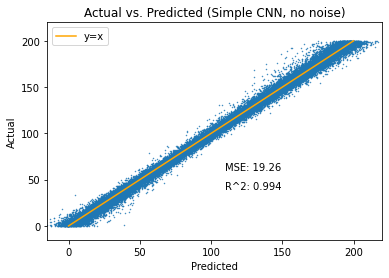

In [ ]:
# Plot pred vs actual
results_noise = model.evaluate(X_test, y_test, batch_size=64)
plt.scatter(y_pred, y_test, s=0.2)
plt.plot([0, 200], [0, 200], '-', color="orange", label="y=x")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xlim([-15, 220])
plt.ylim([-15, 220])
plt.text(110, 60, "MSE: " + str(round(results, 3)))
plt.text(110, 40, "R^2: " + str(round(r2, 3)))
plt.title('Actual vs. Predicted (Simple CNN, no noise)')
plt.legend()
plt.show()

In [ ]:
# Saving train and validation loss
val_loss = history.history['val_loss']
train_loss = history.history['loss']
df_val = pd.DataFrame(val_loss)
df_val.to_csv(MODEL_DIR + '/val_loss.csv', index=False)
df_train = pd.DataFrame(train_loss)
df_train.to_csv(MODEL_DIR + '/train_loss.csv', index=False)

In [ ]:
model.load_weights(os.path.join(MODEL_DIR, "model4-239.h5"))

checkpoint = ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, "model5-{epoch:02d}.h5"), 
    monitor = 'loss',
    save_best_only=True,
    mode='min',
    period=1)

new_history = model.fit(
    x=X_train,
    y=y_train,
    epochs=250,
    verbose=0,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, checkpoint, printEpochCallback(10)]
)

## DeepSpectra CNN

In [ ]:
# Save model while training
MODEL_DIR = "/content/drive/My Drive/temp"
if not os.path.exists(MODEL_DIR): 
  os.makedirs(MODEL_DIR)
checkpoint = ModelCheckpoint(filepath=os.path.join(MODEL_DIR, "model-{epoch:02d}.h5"), save_best_only=True) 

In [ ]:
# Define Model
def deep_spectra_model():
  inputs = keras.Input(shape=(50, 1))
  
  leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.1)

  # Conv 1
  x = layers.Conv1D(filters=8, kernel_size=9, strides=5, activation=leaky_relu)(inputs)
  
  # Conv 2 and 3 (Inception Structure)
  x1 = layers.Conv1D(filters=4, kernel_size=1, padding="same", activation=leaky_relu)(x)
  
  x2 = layers.Conv1D(filters=4, kernel_size=1, padding="same", activation=leaky_relu)(x)
  x2 = layers.Conv1D(filters=4, kernel_size=5, strides=3, padding="same", activation=leaky_relu)(x2)

  x3 = layers.Conv1D(filters=4, kernel_size=1, padding="same", activation=leaky_relu)(x)
  x3 = layers.Conv1D(filters=4, kernel_size=7, strides=3, padding="same", activation=leaky_relu)(x3)

  x4 = layers.MaxPooling1D(pool_size=2, padding="same")(x)
  x4 = layers.Conv1D(filters=4, kernel_size=3, padding="same", activation=leaky_relu)(x4)
  
  x = layers.Concatenate(axis=1)([x1, x2, x3, x4])

  # Flatten
  x = layers.Flatten()(x)

  # F1
  x = layers.Dense(32)(x)

  # Output
  x = layers.Dropout(0.2)(x)
  outputs = layers.Dense(1)(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name="DeepSpectra")
  print(model.summary())

  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.01))

  return model

In [ ]:
# Train Model

# Print progress callback
class printEpochCallback(tf.keras.callbacks.Callback):
  def __init__(self, show_epoch):
    self.show_epoch = show_epoch

  def on_epoch_end(self, epoch, logs=None):
    if(int(epoch) % self.show_epoch) == 0:
      print("Epoch: {:>3} | loss: ".format(epoch) + f"{logs['loss']}" + " | val_loss: " + f"{logs['val_loss']}" + " | lr: " + f"{logs['lr']}")

model = deep_spectra_model()
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=5,
                              min_lr=1e-4)

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=1000,
    verbose=0,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, checkpoint, printEpochCallback(10)]
)

Model: "DeepSpectra"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50, 1)]      0           []                               
                                                                                                  
 conv1d_28 (Conv1D)             (None, 9, 8)         80          ['input_5[0][0]']                
                                                                                                  
 conv1d_30 (Conv1D)             (None, 9, 4)         36          ['conv1d_28[0][0]']              
                                                                                                  
 conv1d_32 (Conv1D)             (None, 9, 4)         36          ['conv1d_28[0][0]']              
                                                                                        

In [ ]:
# MSE
print("Train Loss: ", min(history.history['loss']))
print("Validation Loss: ", min(history.history['val_loss']))

In [ ]:
# Test Model
results = model.evaluate(X_test, y_test, batch_size=64)
print("Test Loss: ", results)

625/625 [==============================] - 2s 3ms/step - loss: 13.7614 - accuracy: 0.0000e+00
Test Loss:  13.76140308380127


In [ ]:
# Test model with noise
results_noise = model.evaluate(X_test_noise, y_test, batch_size=64)
print("Test Loss with Noise: ", results_noise)

625/625 [==============================] - 2s 3ms/step - loss: 14.0968 - accuracy: 0.0000e+00
Test Loss with Noise:  14.096795082092285


In [ ]:
# Generate Predictions
y_pred = model.predict(X_test)

# Calculating R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared: ", r2)

1250/1250 [==============================] - 3s 2ms/step
R-squared:  0.9958723000447772


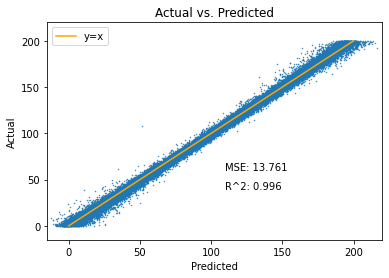

In [ ]:
# Plot pred vs actual
plt.scatter(y_pred, y_test, s=0.2)
plt.plot([0, 200], [0, 200], '-', color="orange", label="y=x")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xlim([-15, 220])
plt.ylim([-15, 220])
plt.text(110, 60, "MSE: " + str(round(results, 3)))
plt.text(110, 40, "R^2: " + str(round(r2, 3)))
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

In [ ]:
# Saving train and validation loss
val_loss = history.history['val_loss']
train_loss = history.history['loss']
df_val = pd.DataFrame(val_loss)
df_val.to_csv(MODEL_DIR + '/val_loss.csv', index=False)
df_train = pd.DataFrame(train_loss)
df_train.to_csv(MODEL_DIR + '/train_loss.csv', index=False)

In [ ]:
# Loading model weights to run from checkpoint
model.load_weights(os.path.join(MODEL_DIR, "model3-74.h5"))

checkpoint = ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, "model4-{epoch:02d}.h5"), 
    monitor = 'loss',
    save_best_only=True,
    mode='min',
    period=1)

new_history = model.fit(
    x=X_train,
    y=y_train,
    epochs=500,
    verbose=0,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, checkpoint, printEpochCallback(10)]
)

Epoch:   0 | loss: 42.37543869018555 | val_loss: 16.010679244995117 | lr: 9.999999747378752e-05
Epoch:  10 | loss: 42.11650466918945 | val_loss: 16.297042846679688 | lr: 9.999999747378752e-05
Epoch:  20 | loss: 42.289859771728516 | val_loss: 15.852331161499023 | lr: 9.999999747378752e-05
Epoch:  30 | loss: 42.080440521240234 | val_loss: 16.139841079711914 | lr: 9.999999747378752e-05
Epoch:  40 | loss: 42.212196350097656 | val_loss: 15.831695556640625 | lr: 9.999999747378752e-05
Epoch:  50 | loss: 42.178707122802734 | val_loss: 16.582584381103516 | lr: 9.999999747378752e-05
Epoch:  60 | loss: 42.02080154418945 | val_loss: 15.534259796142578 | lr: 9.999999747378752e-05
Epoch:  70 | loss: 41.97731399536133 | val_loss: 16.54386329650879 | lr: 9.999999747378752e-05
Epoch:  80 | loss: 41.80459213256836 | val_loss: 15.697160720825195 | lr: 9.999999747378752e-05
Epoch:  90 | loss: 41.71084213256836 | val_loss: 15.701498031616211 | lr: 9.999999747378752e-05
Epoch: 100 | loss: 41.85214614868164 

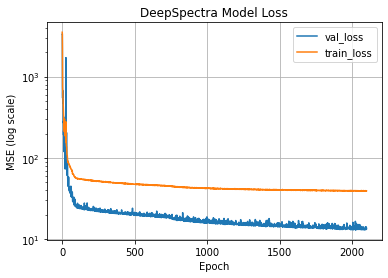

In [ ]:
# Plot model loss
def plot_loss(history):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.set_yscale('log')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.plot(history.history['loss'], label='train_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE (log scale)')
  plt.title('DeepSpectra Model Loss')
  plt.legend()
  plt.grid(True)

plot_loss(history)